In [1]:
from matplotlib import pyplot as plt
import random
import numpy as np
from scipy.signal import find_peaks

# Load Peak Sensor 

In [2]:
ds_gen = []
n = 30
for i in range(n):
    ds_gen.append(np.loadtxt('./peak_sensor/'+str(i)+".txt"))

# Comb Space sensor

In [3]:
def normalize(data):
    peak_ind = np.argmax(data)
    peak_val = data[peak_ind]
    min_val = np.min(data)
    data = (data-min_val)/(peak_val-min_val)
    return data

def get_spacing(ds):
    output = []
    num = len(ds)-1
    for i in range(num):
        for j in range(num - i):
            delta = abs(ds[i+j+1] - ds[i])
            output.append(delta)
    return output

def gaussian_kernel(x,sigma,size):
    return np.exp( -((x-size/2)**2) / (2 * sigma*sigma))

class ds_hist:
    def __init__(self,b = 50,size = 5000):
        self.b = b
        self.size =size        
        self.bins  = np.arange(0, self.size, self.b)
        self.counts =np.zeros(len(self.bins)-1)        
    
    def get_ds_to_hist(self,ds):
        tmp = get_spacing(ds)        
        counts, bins = np.histogram(tmp,self.bins)
        self.counts = self.counts + counts        
        
    def plot_hist(self):
        counts = self.counts
        bins = self.bins
        max_val = bins[np.argmax(counts)]
        plt.stairs(counts, bins,fill=True)
        print("max=",max_val)
        
    def get_counts(self):
        return self.counts
    def get_bins(self):
        return self.bins[1:] 

max= 2300


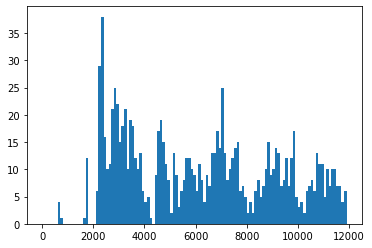

In [4]:
bin_size = 100
h = ds_hist(bin_size,12000)

for i in range(n):
    h.get_ds_to_hist(ds_gen[i])

h.plot_hist()

[ 1700  2300  2800  3400  4600  5100  5700  7000  7500  9100  9700 10800
 11300]


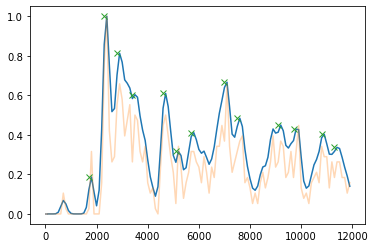

In [5]:
#gausian kernel create
kernel_size = 2000
sigma = 100
x= np.arange(0,kernel_size,bin_size)
kernel = gaussian_kernel(x,sigma,kernel_size)

#histogram info
bins = h.get_bins()
comb_hist = normalize(h.get_counts())

#convolution filter
test = np.correlate(comb_hist,kernel,'same')
test = normalize(test)
#find peaks
peaks, _ = find_peaks(test, height=0.1,distance = 5)
plt.plot(bins,test)
plt.plot(bins,comb_hist,alpha = 0.3)
plt.plot(peaks*bin_size, test[peaks], "x")
plt.plot(np.zeros_like(test), "--", color="gray")
print(peaks*bin_size)
plt.show()

# Tools

In [6]:
def create_peaks(ds,size):
    vs = np.zeros(size)
    i=0;
    for i in range(len(ds)):        
        vs[int(ds[i])] = 1        
        
    return vs


def plot_data(ds,raw_data,start =0,stop =0):
    if (stop == 0): stop = len(raw_data)
    if (start>stop): print("stop setting error")
    x = np.arange(0,len(raw_data),1)
    vs = create_peaks(ds,data_size)
    min_val = np.min(raw_data)
    mag = np.max(raw_data) - min_val
    
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(6)
    plt.plot(x[start:stop], vs[start:stop]*mag+min_val,alpha=0.3,color='r')
    plt.plot(x[start:stop],raw_data[start:stop],color='gray',alpha=0.7) 

# Programming SSF

In [7]:
# at t
# ds(t) = ds_gen[t]
# ds 資料結構: (one scan)
# 
#  [ x1,x2,x3,x4.... ] 
#
# comb space 需有上下限
# in the case, I supposed 5000(up) and 1000(down)
#
#
#  state = [x, x_var, c, c_var]
#  x     = offest point(initial point)
#  x_var = variance of x
#  c     = comb space
#  c_var = variance of comb space
#

In [8]:
class SSF:
    def __init__(self,state,size):
        self.x0 = state[0]
        self.x0_var = state[1]
        self.x = np.arange(state[0], size, state[2])
        self.x_active = np.zeros(len(self.x))
        self.x_var = np.ones(len(self.x))*state[1]
        self.c = state[2]
        self.c_var = state[3]
        self.ds =[]
        self.size =size
        self.start =0
        
    def predict(self):
        ##################
        #
        # To do : how to predict the state of x and c
        #
        ######################
        if (self.start):            
            down_lim = self.c-500
            up_lim = 2*down_lim
            delta = 0
            c = []
            c_ave =self.c
            x0_ave = 0
            c_std =0
            x0_std = 0
#             for i in range(len(self.x)-1):
#                 if(self.x_active[i]):    
#                     #self.x_active[i] = 0
#                     for j in range(len(self.x)-1 - i):
#                         if(self.x_active[i+j+1]):  
#                             #self.x_active[i+j+1] =0
#                             delta = abs(self.x[i+j+1] - self.x[i])
#                             for k in range(2):
#                                 if ((delta > (k+1)*down_lim) & (delta <(k+1)*up_lim)):
#                                     c.append(delta/(k+1))



            
#             c_ave = round(np.average(c))
#             c_var = np.std(c)
            x0 =[] 
            for i in range(len(self.x)):
                if(self.x_active[i]):
                    x = self.x[i]
                    while(x>c_ave):
                        x = x - c_ave
                    x0.append(x)
            x0_ave = round(np.average(x0))       
            x0_var = np.std(x0)
            
            if((x0_ave !=0) & (c_ave !=0)):
                self.x0 =  round((x0_ave*self.x0_var+self.x0*x0_var)/(x0_var+self.x0_var))
                self.x0_var =  1/(1/x0_var+1/self.x0_var) + 5
                self.x = np.arange(self.x0,self.size,c_ave)
                #########################
                #  design how to add x_var 
                ############################
#                 self.c =  round((c_ave*self.c_var+self.c*c_var)/(self.c_var+c_var))
#                 self.c_var = 1/(1/self.c_var + 1/c_var) + 50
                #not sure whether need to reset that
                self.x_active = np.zeros(len(self.x))
                return c
        return 0
        
        
    def get_measu (self,ds):
        self.ds=ds
        
    
    def update(self,window):
        search_zone = 5
        ds_var = 20
        active_count=0
        self.start = 1
        for i in range(len(self.ds)):
            # find near peaks of prediction: 
            # warning: 如果剛好在正中間，選小的
            ans = []
            for j in range(len(self.x)):
                delta = abs(self.ds[i]-self.x[j])
                ans.append(delta)
            min_delta = min(ans)    
            near_pt = ans.index(min_delta)
            
            
            if( min_delta  < window):                
                self.x_active[near_pt] = 1
                self.x[near_pt] = round((self.x[near_pt] * self.x_var[near_pt] + self.ds[i]* ds_var )/(self.x_var[near_pt] + ds_var ))
                self.x_var[near_pt] = round( 1/(1/self.x_var[near_pt]+1/ds_var)) + 5
                active_count =  active_count +1
        #print('active',sum(self.x_active),len(self.ds))
        return active_count, [self.x0,self.x0_var, self.c, self.c_var]
    
    def get_x_active(self):
        return self.x_active
    
    def create_predict_peaks(self,size):
        vs = np.zeros(size)
        i=0;
        vs[self.x0] =1
        for i in range(len(self.x)):           
            vs[self.x] = 1
        return vs

In [9]:
#initialize...
comb_space = 2300
state =[1500,1000,comb_space,500]
data_size = 250000
jitter = round(comb_space/2) #假設n scan 與 n+1 scan 的jitter
z = SSF(state, data_size)

# assign round n
n=10
for i in range(n):
    tmp = z.predict()
    z.get_measu(ds_gen[i])
    active_count, state = z.update(jitter)
    print("round:",i,", active:",active_count, np.where(z.get_x_active() == 1))
    print(active_count, state)
    print(" ")

round: 0 , active: 15 (array([20, 54, 55, 61, 63, 64, 65, 67, 70, 71, 73, 74, 75, 78, 98],
      dtype=int64),)
15 [1500, 1000, 2300, 500]
 
round: 1 , active: 17 (array([13, 20, 21, 53, 55, 61, 63, 64, 65, 67, 70, 72, 74, 75, 76, 78, 98],
      dtype=int64),)
17 [1501, 18.303781231632012, 2300, 500]
 
round: 2 , active: 14 (array([12, 20, 54, 61, 63, 64, 66, 68, 70, 72, 73, 74, 75, 98],
      dtype=int64),)
14 [1498, 22.074768241603735, 2300, 500]
 
round: 3 , active: 14 (array([12, 20, 54, 61, 63, 65, 66, 69, 71, 72, 73, 74, 75, 98],
      dtype=int64),)
14 [1501, 25.779419033333987, 2300, 500]
 
round: 4 , active: 12 (array([20, 55, 61, 64, 65, 67, 68, 71, 73, 74, 75, 98], dtype=int64),)
12 [1494, 28.734555926654753, 2300, 500]
 
round: 5 , active: 17 (array([12, 20, 52, 53, 55, 61, 63, 64, 65, 67, 70, 72, 74, 75, 76, 91, 98],
      dtype=int64),)
17 [1501, 31.63618005090255, 2300, 500]
 
round: 6 , active: 13 (array([19, 54, 61, 62, 63, 65, 66, 70, 71, 73, 74, 75, 98], dtype=int64)

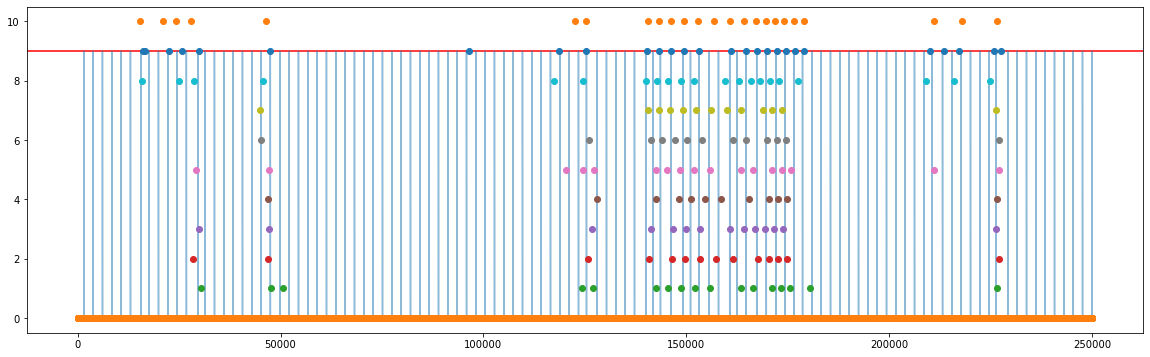

In [10]:
x= np.arange(0, data_size,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=(n-1), color='r', linestyle='-')
vs = z.create_predict_peaks(data_size)
plt.plot(x,vs*(n-1),alpha = 0.5)
for num in range(n+1):
    y = create_peaks(ds_gen[num],data_size) *(num)
    plt.plot(x,y, 'o')   

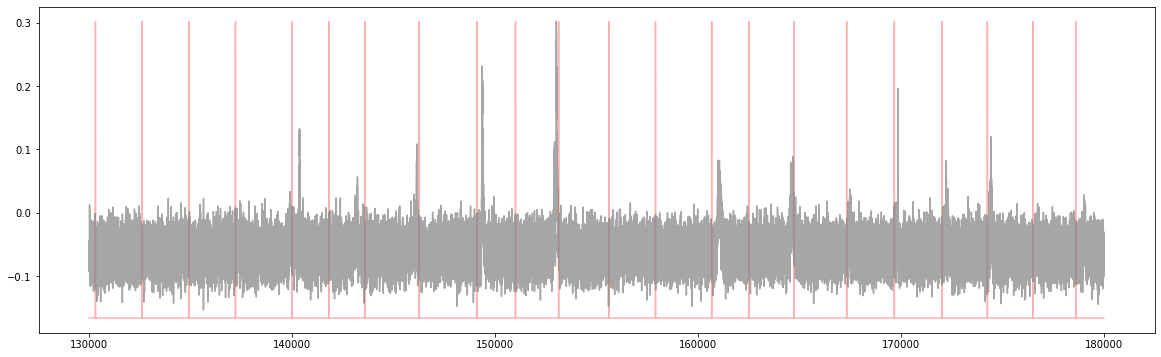

In [11]:
ds = z.x
raw_data = np.loadtxt("../simulator/B/down/"+str(n-1)+".txt")
plot_data(ds,raw_data,130000,180000)

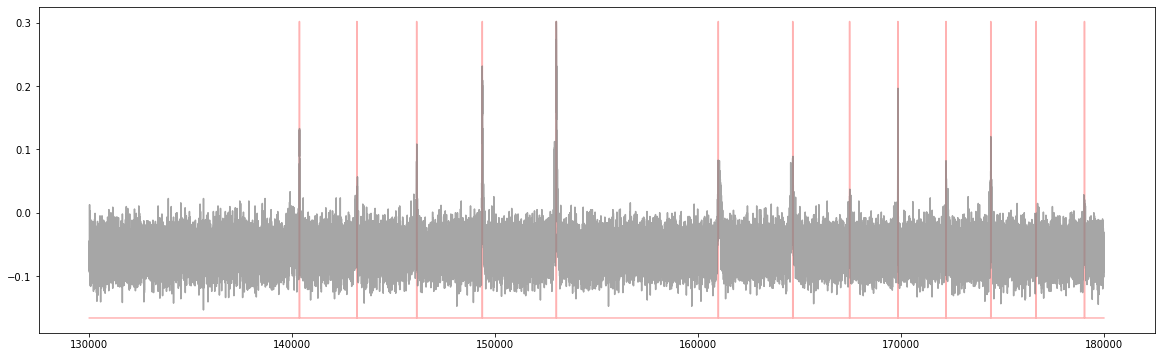

In [12]:
plot_data(ds_gen[n-1],raw_data,130000,180000)